In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Input, Reshape, Conv1D, Dropout, Flatten
from keras.models import Model
from keras.optimizers import SGD, Adam
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset  # sin 函数偏移
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])  # sin 函数周期
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

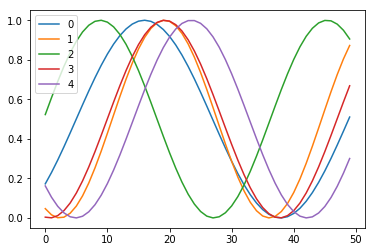

In [6]:
ax = pd.DataFrame(np.transpose(sample_data(5))).plot()

In [7]:
def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out


G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


In [9]:
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out
D_in = Input(shape=[50])
D, D_out = get_discriminative(D_in)
D.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 50)            300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                115050    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [10]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable


def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out


GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_1 (Model)              (None, 50)                12250     
_________________________________________________________________
model_2 (Model)              (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [12]:
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2 * n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y


def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)


pretrain(G, D)

Epoch 1/1


   32/20000 [..............................] - ETA: 2:42 - loss: 0.7131

  672/20000 [>.............................] - ETA: 8s - loss: 0.2122  

 1312/20000 [>.............................] - ETA: 5s - loss: 0.1107

 1920/20000 [=>............................] - ETA: 3s - loss: 0.0759

 2592/20000 [==>...........................] - ETA: 3s - loss: 0.0564

 3296/20000 [===>..........................] - ETA: 2s - loss: 0.0444

 3872/20000 [====>.........................] - ETA: 2s - loss: 0.0379

 4448/20000 [=====>........................] - ETA: 2s - loss: 0.0330

 5152/20000 [======>.......................] - ETA: 1s - loss: 0.0285

 5824/20000 [=======>......................] - ETA: 1s - loss: 0.0253

 6400/20000 [========>.....................] - ETA: 1s - loss: 0.0230

 7072/20000 [=========>....................] - ETA: 1s - loss: 0.0208

 7712/20000 [==========>...................] - ETA: 1s - loss: 0.0191

 8416/20000 [===========>..................] - ETA: 1s - loss: 0.0175

 9152/20000 [============>.................] - ETA: 1s - loss: 0.0161

 9792/20000 [=============>................] - ETA: 1s - loss: 0.0151

10464/20000 [==============>...............] - ETA: 0s - loss: 0.0141

11200/20000 [===============>..............] - ETA: 0s - loss: 0.0132

11936/20000 [================>.............] - ETA: 0s - loss: 0.0124

12608/20000 [=================>............] - ETA: 0s - loss: 0.0117

13216/20000 [==================>...........] - ETA: 0s - loss: 0.0112

13888/20000 [===================>..........] - ETA: 0s - loss: 0.0107

14624/20000 [====================>.........] - ETA: 0s - loss: 0.0101

15360/20000 [======================>.......] - ETA: 0s - loss: 0.0096

16128/20000 [=======================>......] - ETA: 0s - loss: 0.0092

16896/20000 [========================>.....] - ETA: 0s - loss: 0.0088

17664/20000 [=========================>....] - ETA: 0s - loss: 0.0084

18400/20000 [==========================>...] - ETA: 0s - loss: 0.0081

19136/20000 [===========================>..] - ETA: 0s - loss: 0.0077

19872/20000 [============================>.] - ETA: 0s - loss: 0.0075

20000/20000 [==============================] - 2s 88us/step - loss: 0.0074


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:02<22:10,  2.67s/it]

  0%|          | 2/500 [00:03<18:34,  2.24s/it]

  1%|          | 3/500 [00:05<15:51,  1.91s/it]

  1%|          | 4/500 [00:06<13:52,  1.68s/it]

  1%|          | 5/500 [00:07<12:28,  1.51s/it]

  1%|          | 6/500 [00:08<11:27,  1.39s/it]

  1%|▏         | 7/500 [00:09<10:47,  1.31s/it]

  2%|▏         | 8/500 [00:10<10:23,  1.27s/it]

  2%|▏         | 9/500 [00:11<10:03,  1.23s/it]

  2%|▏         | 10/500 [00:13<09:55,  1.21s/it]

  2%|▏         | 11/500 [00:14<09:47,  1.20s/it]

  2%|▏         | 12/500 [00:15<09:40,  1.19s/it]

  3%|▎         | 13/500 [00:16<09:35,  1.18s/it]

  3%|▎         | 14/500 [00:17<09:30,  1.17s/it]

  3%|▎         | 15/500 [00:18<09:27,  1.17s/it]

  3%|▎         | 16/500 [00:20<09:35,  1.19s/it]

  3%|▎         | 17/500 [00:21<09:31,  1.18s/it]

  4%|▎         | 18/500 [00:22<09:32,  1.19s/it]

  4%|▍         | 19/500 [00:23<09:32,  1.19s/it]

  4%|▍         | 20/500 [00:24<09:32,  1.19s/it]

  4%|▍         | 21/500 [00:25<09:23,  1.18s/it]

  4%|▍         | 22/500 [00:27<09:20,  1.17s/it]

  5%|▍         | 23/500 [00:28<09:17,  1.17s/it]

  5%|▍         | 24/500 [00:29<09:14,  1.16s/it]

  5%|▌         | 25/500 [00:30<09:12,  1.16s/it]

  5%|▌         | 26/500 [00:31<09:11,  1.16s/it]

  5%|▌         | 27/500 [00:33<09:19,  1.18s/it]

  6%|▌         | 28/500 [00:34<09:15,  1.18s/it]

  6%|▌         | 29/500 [00:35<09:14,  1.18s/it]

  6%|▌         | 30/500 [00:36<09:13,  1.18s/it]

  6%|▌         | 31/500 [00:37<09:51,  1.26s/it]

  6%|▋         | 32/500 [00:39<10:19,  1.32s/it]

  7%|▋         | 33/500 [00:41<10:51,  1.39s/it]

  7%|▋         | 34/500 [00:42<10:56,  1.41s/it]

  7%|▋         | 35/500 [00:43<10:38,  1.37s/it]

  7%|▋         | 36/500 [00:44<10:16,  1.33s/it]

  7%|▋         | 37/500 [00:46<10:01,  1.30s/it]

  8%|▊         | 38/500 [00:47<09:41,  1.26s/it]

  8%|▊         | 39/500 [00:48<09:25,  1.23s/it]

  8%|▊         | 40/500 [00:49<09:17,  1.21s/it]

  8%|▊         | 41/500 [00:50<09:09,  1.20s/it]

  8%|▊         | 42/500 [00:52<09:01,  1.18s/it]

  9%|▊         | 43/500 [00:53<08:54,  1.17s/it]

  9%|▉         | 44/500 [00:54<08:58,  1.18s/it]

  9%|▉         | 45/500 [00:55<09:09,  1.21s/it]

  9%|▉         | 46/500 [00:56<09:11,  1.22s/it]

  9%|▉         | 47/500 [00:58<09:07,  1.21s/it]

 10%|▉         | 48/500 [00:59<09:14,  1.23s/it]

 10%|▉         | 49/500 [01:00<09:19,  1.24s/it]

 10%|█         | 50/500 [01:01<09:30,  1.27s/it]

Epoch #50: Generative Loss: 6.758290767669678, Discriminative Loss: 0.07701074331998825


 10%|█         | 51/500 [01:03<09:34,  1.28s/it]

 10%|█         | 52/500 [01:04<10:10,  1.36s/it]

 11%|█         | 53/500 [01:06<09:55,  1.33s/it]

 11%|█         | 54/500 [01:07<10:00,  1.35s/it]

 11%|█         | 55/500 [01:08<09:42,  1.31s/it]

 11%|█         | 56/500 [01:09<09:40,  1.31s/it]

 11%|█▏        | 57/500 [01:11<09:37,  1.30s/it]

 12%|█▏        | 58/500 [01:12<09:29,  1.29s/it]

 12%|█▏        | 59/500 [01:13<09:13,  1.25s/it]

 12%|█▏        | 60/500 [01:14<09:07,  1.24s/it]

 12%|█▏        | 61/500 [01:16<09:06,  1.24s/it]

 12%|█▏        | 62/500 [01:17<09:09,  1.25s/it]

 13%|█▎        | 63/500 [01:18<09:06,  1.25s/it]

 13%|█▎        | 64/500 [01:20<09:17,  1.28s/it]

 13%|█▎        | 65/500 [01:21<09:15,  1.28s/it]

 13%|█▎        | 66/500 [01:22<09:02,  1.25s/it]

 13%|█▎        | 67/500 [01:23<09:00,  1.25s/it]

 14%|█▎        | 68/500 [01:25<09:05,  1.26s/it]

 14%|█▍        | 69/500 [01:26<09:07,  1.27s/it]

 14%|█▍        | 70/500 [01:27<08:53,  1.24s/it]

 14%|█▍        | 71/500 [01:28<08:46,  1.23s/it]

 14%|█▍        | 72/500 [01:29<08:56,  1.25s/it]

 15%|█▍        | 73/500 [01:31<09:01,  1.27s/it]

 15%|█▍        | 74/500 [01:32<09:08,  1.29s/it]

 15%|█▌        | 75/500 [01:33<09:04,  1.28s/it]

 15%|█▌        | 76/500 [01:35<08:52,  1.26s/it]

 15%|█▌        | 77/500 [01:36<08:46,  1.24s/it]

 16%|█▌        | 78/500 [01:37<08:38,  1.23s/it]

 16%|█▌        | 79/500 [01:38<08:27,  1.20s/it]

 16%|█▌        | 80/500 [01:39<08:24,  1.20s/it]

 16%|█▌        | 81/500 [01:40<08:17,  1.19s/it]

 16%|█▋        | 82/500 [01:42<08:14,  1.18s/it]

 17%|█▋        | 83/500 [01:43<08:16,  1.19s/it]

 17%|█▋        | 84/500 [01:44<08:16,  1.19s/it]

 17%|█▋        | 85/500 [01:45<08:14,  1.19s/it]

 17%|█▋        | 86/500 [01:46<08:11,  1.19s/it]

 17%|█▋        | 87/500 [01:48<08:09,  1.18s/it]

 18%|█▊        | 88/500 [01:49<08:11,  1.19s/it]

 18%|█▊        | 89/500 [01:50<08:12,  1.20s/it]

 18%|█▊        | 90/500 [01:51<08:11,  1.20s/it]

 18%|█▊        | 91/500 [01:53<08:23,  1.23s/it]

 18%|█▊        | 92/500 [01:54<08:19,  1.22s/it]

 19%|█▊        | 93/500 [01:55<08:07,  1.20s/it]

 19%|█▉        | 94/500 [01:56<08:03,  1.19s/it]

 19%|█▉        | 95/500 [01:57<07:57,  1.18s/it]

 19%|█▉        | 96/500 [01:58<07:55,  1.18s/it]

 19%|█▉        | 97/500 [02:00<08:05,  1.20s/it]

 20%|█▉        | 98/500 [02:01<08:05,  1.21s/it]

 20%|█▉        | 99/500 [02:02<07:55,  1.19s/it]

 20%|██        | 100/500 [02:03<08:00,  1.20s/it]

Epoch #100: Generative Loss: 2.7522847652435303, Discriminative Loss: 0.2045443058013916


 20%|██        | 101/500 [02:04<08:07,  1.22s/it]

 20%|██        | 102/500 [02:06<08:00,  1.21s/it]

 21%|██        | 103/500 [02:07<07:50,  1.18s/it]

 21%|██        | 104/500 [02:08<07:43,  1.17s/it]

 21%|██        | 105/500 [02:09<07:38,  1.16s/it]

 21%|██        | 106/500 [02:10<07:40,  1.17s/it]

 21%|██▏       | 107/500 [02:11<07:40,  1.17s/it]

 22%|██▏       | 108/500 [02:13<07:46,  1.19s/it]

 22%|██▏       | 109/500 [02:14<07:47,  1.20s/it]

 22%|██▏       | 110/500 [02:15<07:45,  1.19s/it]

 22%|██▏       | 111/500 [02:16<07:43,  1.19s/it]

 22%|██▏       | 112/500 [02:17<07:36,  1.18s/it]

 23%|██▎       | 113/500 [02:19<07:30,  1.17s/it]

 23%|██▎       | 114/500 [02:20<07:27,  1.16s/it]

 23%|██▎       | 115/500 [02:21<07:21,  1.15s/it]

 23%|██▎       | 116/500 [02:22<07:17,  1.14s/it]

 23%|██▎       | 117/500 [02:23<07:15,  1.14s/it]

 24%|██▎       | 118/500 [02:24<07:14,  1.14s/it]

 24%|██▍       | 119/500 [02:25<07:16,  1.15s/it]

 24%|██▍       | 120/500 [02:27<07:15,  1.15s/it]

 24%|██▍       | 121/500 [02:28<07:13,  1.14s/it]

 24%|██▍       | 122/500 [02:29<07:10,  1.14s/it]

 25%|██▍       | 123/500 [02:30<07:10,  1.14s/it]

 25%|██▍       | 124/500 [02:31<07:09,  1.14s/it]

 25%|██▌       | 125/500 [02:32<07:09,  1.15s/it]

 25%|██▌       | 126/500 [02:33<07:05,  1.14s/it]

 25%|██▌       | 127/500 [02:35<07:06,  1.14s/it]

 26%|██▌       | 128/500 [02:36<07:04,  1.14s/it]

 26%|██▌       | 129/500 [02:37<07:00,  1.13s/it]

 26%|██▌       | 130/500 [02:38<07:00,  1.14s/it]

 26%|██▌       | 131/500 [02:39<07:00,  1.14s/it]

 26%|██▋       | 132/500 [02:40<06:58,  1.14s/it]

 27%|██▋       | 133/500 [02:41<07:01,  1.15s/it]

 27%|██▋       | 134/500 [02:42<07:00,  1.15s/it]

 27%|██▋       | 135/500 [02:44<06:56,  1.14s/it]

 27%|██▋       | 136/500 [02:45<06:52,  1.13s/it]

 27%|██▋       | 137/500 [02:46<06:49,  1.13s/it]

 28%|██▊       | 138/500 [02:47<06:46,  1.12s/it]

 28%|██▊       | 139/500 [02:48<06:44,  1.12s/it]

 28%|██▊       | 140/500 [02:49<06:43,  1.12s/it]

 28%|██▊       | 141/500 [02:50<06:45,  1.13s/it]

 28%|██▊       | 142/500 [02:51<06:46,  1.13s/it]

 29%|██▊       | 143/500 [02:53<06:47,  1.14s/it]

 29%|██▉       | 144/500 [02:54<06:53,  1.16s/it]

 29%|██▉       | 145/500 [02:55<06:53,  1.17s/it]

 29%|██▉       | 146/500 [02:56<06:53,  1.17s/it]

 29%|██▉       | 147/500 [02:58<07:09,  1.22s/it]

 30%|██▉       | 148/500 [02:59<07:05,  1.21s/it]

 30%|██▉       | 149/500 [03:00<07:14,  1.24s/it]

 30%|███       | 150/500 [03:01<07:19,  1.26s/it]

Epoch #150: Generative Loss: 5.704677581787109, Discriminative Loss: 0.046810682862997055


 30%|███       | 151/500 [03:03<07:10,  1.23s/it]

 30%|███       | 152/500 [03:04<06:59,  1.21s/it]

 31%|███       | 153/500 [03:05<06:52,  1.19s/it]

 31%|███       | 154/500 [03:06<06:47,  1.18s/it]

 31%|███       | 155/500 [03:07<06:41,  1.16s/it]

 31%|███       | 156/500 [03:08<06:46,  1.18s/it]

 31%|███▏      | 157/500 [03:09<06:42,  1.17s/it]

 32%|███▏      | 158/500 [03:11<06:50,  1.20s/it]

 32%|███▏      | 159/500 [03:12<06:47,  1.20s/it]

 32%|███▏      | 160/500 [03:13<07:02,  1.24s/it]

 32%|███▏      | 161/500 [03:15<07:02,  1.25s/it]

 32%|███▏      | 162/500 [03:16<07:03,  1.25s/it]

 33%|███▎      | 163/500 [03:17<07:02,  1.25s/it]

 33%|███▎      | 164/500 [03:18<07:04,  1.26s/it]

 33%|███▎      | 165/500 [03:20<06:55,  1.24s/it]

 33%|███▎      | 166/500 [03:21<06:53,  1.24s/it]

 33%|███▎      | 167/500 [03:22<06:43,  1.21s/it]

 34%|███▎      | 168/500 [03:23<06:34,  1.19s/it]

 34%|███▍      | 169/500 [03:24<06:26,  1.17s/it]

 34%|███▍      | 170/500 [03:25<06:28,  1.18s/it]

 34%|███▍      | 171/500 [03:26<06:24,  1.17s/it]

 34%|███▍      | 172/500 [03:28<06:35,  1.21s/it]

 35%|███▍      | 173/500 [03:29<06:40,  1.23s/it]

 35%|███▍      | 174/500 [03:30<06:40,  1.23s/it]

 35%|███▌      | 175/500 [03:31<06:32,  1.21s/it]

 35%|███▌      | 176/500 [03:33<06:24,  1.19s/it]

 35%|███▌      | 177/500 [03:34<06:19,  1.17s/it]

 36%|███▌      | 178/500 [03:35<06:15,  1.17s/it]

 36%|███▌      | 179/500 [03:36<06:18,  1.18s/it]

 36%|███▌      | 180/500 [03:37<06:26,  1.21s/it]

 36%|███▌      | 181/500 [03:39<06:20,  1.19s/it]

 36%|███▋      | 182/500 [03:40<06:18,  1.19s/it]

 37%|███▋      | 183/500 [03:41<06:12,  1.18s/it]

 37%|███▋      | 184/500 [03:42<06:06,  1.16s/it]

 37%|███▋      | 185/500 [03:43<06:04,  1.16s/it]

 37%|███▋      | 186/500 [03:44<05:59,  1.15s/it]

 37%|███▋      | 187/500 [03:45<05:57,  1.14s/it]

 38%|███▊      | 188/500 [03:47<05:54,  1.14s/it]

 38%|███▊      | 189/500 [03:48<05:52,  1.14s/it]

 38%|███▊      | 190/500 [03:49<05:51,  1.13s/it]

 38%|███▊      | 191/500 [03:50<05:50,  1.13s/it]

 38%|███▊      | 192/500 [03:51<05:47,  1.13s/it]

 39%|███▊      | 193/500 [03:52<05:46,  1.13s/it]

 39%|███▉      | 194/500 [03:53<05:43,  1.12s/it]

 39%|███▉      | 195/500 [03:54<05:42,  1.12s/it]

 39%|███▉      | 196/500 [03:55<05:39,  1.12s/it]

 39%|███▉      | 197/500 [03:57<05:39,  1.12s/it]

 40%|███▉      | 198/500 [03:58<05:37,  1.12s/it]

 40%|███▉      | 199/500 [03:59<05:38,  1.13s/it]

 40%|████      | 200/500 [04:00<05:39,  1.13s/it]

Epoch #200: Generative Loss: 3.8996379375457764, Discriminative Loss: 0.07946819067001343


 40%|████      | 201/500 [04:01<05:38,  1.13s/it]

 40%|████      | 202/500 [04:02<05:37,  1.13s/it]

 41%|████      | 203/500 [04:03<05:36,  1.13s/it]

 41%|████      | 204/500 [04:05<05:35,  1.13s/it]

 41%|████      | 205/500 [04:06<05:33,  1.13s/it]

 41%|████      | 206/500 [04:07<05:32,  1.13s/it]

 41%|████▏     | 207/500 [04:08<05:30,  1.13s/it]

 42%|████▏     | 208/500 [04:09<05:29,  1.13s/it]

 42%|████▏     | 209/500 [04:10<05:28,  1.13s/it]

 42%|████▏     | 210/500 [04:11<05:27,  1.13s/it]

 42%|████▏     | 211/500 [04:12<05:27,  1.13s/it]

 42%|████▏     | 212/500 [04:14<05:26,  1.13s/it]

 43%|████▎     | 213/500 [04:15<05:26,  1.14s/it]

 43%|████▎     | 214/500 [04:16<05:23,  1.13s/it]

 43%|████▎     | 215/500 [04:17<05:23,  1.13s/it]

 43%|████▎     | 216/500 [04:18<05:20,  1.13s/it]

 43%|████▎     | 217/500 [04:19<05:20,  1.13s/it]

 44%|████▎     | 218/500 [04:20<05:19,  1.13s/it]

 44%|████▍     | 219/500 [04:22<05:18,  1.13s/it]

 44%|████▍     | 220/500 [04:23<05:15,  1.13s/it]

 44%|████▍     | 221/500 [04:24<05:15,  1.13s/it]

 44%|████▍     | 222/500 [04:25<05:14,  1.13s/it]

 45%|████▍     | 223/500 [04:26<05:12,  1.13s/it]

 45%|████▍     | 224/500 [04:27<05:09,  1.12s/it]

 45%|████▌     | 225/500 [04:28<05:08,  1.12s/it]

 45%|████▌     | 226/500 [04:29<05:07,  1.12s/it]

 45%|████▌     | 227/500 [04:30<05:06,  1.12s/it]

 46%|████▌     | 228/500 [04:32<05:04,  1.12s/it]

 46%|████▌     | 229/500 [04:33<05:03,  1.12s/it]

 46%|████▌     | 230/500 [04:34<05:03,  1.12s/it]

 46%|████▌     | 231/500 [04:35<05:02,  1.12s/it]

 46%|████▋     | 232/500 [04:36<05:01,  1.12s/it]

 47%|████▋     | 233/500 [04:37<05:00,  1.13s/it]

 47%|████▋     | 234/500 [04:38<05:00,  1.13s/it]

 47%|████▋     | 235/500 [04:39<04:58,  1.13s/it]

 47%|████▋     | 236/500 [04:41<04:57,  1.13s/it]

 47%|████▋     | 237/500 [04:42<04:56,  1.13s/it]

 48%|████▊     | 238/500 [04:43<04:56,  1.13s/it]

 48%|████▊     | 239/500 [04:44<04:55,  1.13s/it]

 48%|████▊     | 240/500 [04:45<04:53,  1.13s/it]

 48%|████▊     | 241/500 [04:46<04:51,  1.13s/it]

 48%|████▊     | 242/500 [04:47<04:50,  1.13s/it]

 49%|████▊     | 243/500 [04:49<04:48,  1.12s/it]

 49%|████▉     | 244/500 [04:50<04:47,  1.12s/it]

 49%|████▉     | 245/500 [04:51<04:47,  1.13s/it]

 49%|████▉     | 246/500 [04:52<04:45,  1.12s/it]

 49%|████▉     | 247/500 [04:53<04:44,  1.12s/it]

 50%|████▉     | 248/500 [04:54<04:43,  1.13s/it]

 50%|████▉     | 249/500 [04:55<04:42,  1.12s/it]

 50%|█████     | 250/500 [04:56<04:41,  1.13s/it]

Epoch #250: Generative Loss: 3.997666358947754, Discriminative Loss: 0.055804479867219925


 50%|█████     | 251/500 [04:58<04:41,  1.13s/it]

 50%|█████     | 252/500 [04:59<04:40,  1.13s/it]

 51%|█████     | 253/500 [05:00<04:39,  1.13s/it]

 51%|█████     | 254/500 [05:01<04:38,  1.13s/it]

 51%|█████     | 255/500 [05:02<04:36,  1.13s/it]

 51%|█████     | 256/500 [05:03<04:44,  1.17s/it]

 51%|█████▏    | 257/500 [05:05<04:48,  1.19s/it]

 52%|█████▏    | 258/500 [05:06<04:45,  1.18s/it]

 52%|█████▏    | 259/500 [05:07<04:45,  1.18s/it]

 52%|█████▏    | 260/500 [05:08<04:43,  1.18s/it]

 52%|█████▏    | 261/500 [05:09<04:54,  1.23s/it]

 52%|█████▏    | 262/500 [05:11<05:05,  1.28s/it]

 53%|█████▎    | 263/500 [05:12<04:57,  1.25s/it]

 53%|█████▎    | 264/500 [05:13<04:55,  1.25s/it]

 53%|█████▎    | 265/500 [05:14<04:46,  1.22s/it]

 53%|█████▎    | 266/500 [05:16<04:54,  1.26s/it]

 53%|█████▎    | 267/500 [05:17<04:59,  1.29s/it]

 54%|█████▎    | 268/500 [05:18<05:02,  1.31s/it]

 54%|█████▍    | 269/500 [05:20<05:06,  1.33s/it]

 54%|█████▍    | 270/500 [05:21<05:03,  1.32s/it]

 54%|█████▍    | 271/500 [05:22<04:49,  1.26s/it]

 54%|█████▍    | 272/500 [05:23<04:40,  1.23s/it]

 55%|█████▍    | 273/500 [05:25<04:36,  1.22s/it]

 55%|█████▍    | 274/500 [05:26<04:31,  1.20s/it]

 55%|█████▌    | 275/500 [05:27<04:30,  1.20s/it]

 55%|█████▌    | 276/500 [05:28<04:30,  1.21s/it]

 55%|█████▌    | 277/500 [05:29<04:31,  1.22s/it]

 56%|█████▌    | 278/500 [05:31<04:29,  1.21s/it]

 56%|█████▌    | 279/500 [05:32<04:25,  1.20s/it]

 56%|█████▌    | 280/500 [05:33<04:20,  1.19s/it]

 56%|█████▌    | 281/500 [05:34<04:21,  1.19s/it]

 56%|█████▋    | 282/500 [05:35<04:20,  1.20s/it]

 57%|█████▋    | 283/500 [05:37<04:28,  1.24s/it]

 57%|█████▋    | 284/500 [05:38<04:36,  1.28s/it]

 57%|█████▋    | 285/500 [05:39<04:35,  1.28s/it]

 57%|█████▋    | 286/500 [05:41<04:25,  1.24s/it]

 57%|█████▋    | 287/500 [05:42<04:18,  1.21s/it]

 58%|█████▊    | 288/500 [05:43<04:17,  1.21s/it]

 58%|█████▊    | 289/500 [05:44<04:16,  1.22s/it]

 58%|█████▊    | 290/500 [05:45<04:11,  1.20s/it]

 58%|█████▊    | 291/500 [05:46<04:07,  1.19s/it]

 58%|█████▊    | 292/500 [05:48<04:04,  1.17s/it]

 59%|█████▊    | 293/500 [05:49<04:14,  1.23s/it]

 59%|█████▉    | 294/500 [05:50<04:18,  1.26s/it]

 59%|█████▉    | 295/500 [05:51<04:16,  1.25s/it]

 59%|█████▉    | 296/500 [05:53<04:18,  1.26s/it]

 59%|█████▉    | 297/500 [05:54<04:11,  1.24s/it]

 60%|█████▉    | 298/500 [05:55<04:09,  1.24s/it]

 60%|█████▉    | 299/500 [05:57<04:15,  1.27s/it]

 60%|██████    | 300/500 [05:58<04:09,  1.25s/it]

Epoch #300: Generative Loss: 4.670999526977539, Discriminative Loss: 0.03282748907804489


 60%|██████    | 301/500 [05:59<04:01,  1.21s/it]

 60%|██████    | 302/500 [06:00<03:56,  1.20s/it]

 61%|██████    | 303/500 [06:01<03:54,  1.19s/it]

 61%|██████    | 304/500 [06:02<03:49,  1.17s/it]

 61%|██████    | 305/500 [06:03<03:46,  1.16s/it]

 61%|██████    | 306/500 [06:05<03:43,  1.15s/it]

 61%|██████▏   | 307/500 [06:06<03:42,  1.15s/it]

 62%|██████▏   | 308/500 [06:07<03:41,  1.15s/it]

 62%|██████▏   | 309/500 [06:08<03:41,  1.16s/it]

 62%|██████▏   | 310/500 [06:09<03:38,  1.15s/it]

 62%|██████▏   | 311/500 [06:10<03:37,  1.15s/it]

 62%|██████▏   | 312/500 [06:11<03:35,  1.14s/it]

 63%|██████▎   | 313/500 [06:13<03:34,  1.15s/it]

 63%|██████▎   | 314/500 [06:14<03:31,  1.14s/it]

 63%|██████▎   | 315/500 [06:15<03:30,  1.14s/it]

 63%|██████▎   | 316/500 [06:16<03:28,  1.13s/it]

 63%|██████▎   | 317/500 [06:17<03:25,  1.12s/it]

 64%|██████▎   | 318/500 [06:18<03:23,  1.12s/it]

 64%|██████▍   | 319/500 [06:19<03:22,  1.12s/it]

 64%|██████▍   | 320/500 [06:20<03:22,  1.13s/it]

 64%|██████▍   | 321/500 [06:22<03:21,  1.13s/it]

 64%|██████▍   | 322/500 [06:23<03:19,  1.12s/it]

 65%|██████▍   | 323/500 [06:24<03:19,  1.12s/it]

 65%|██████▍   | 324/500 [06:25<03:17,  1.12s/it]

 65%|██████▌   | 325/500 [06:26<03:16,  1.12s/it]

 65%|██████▌   | 326/500 [06:27<03:13,  1.11s/it]

 65%|██████▌   | 327/500 [06:28<03:12,  1.11s/it]

 66%|██████▌   | 328/500 [06:29<03:11,  1.11s/it]

 66%|██████▌   | 329/500 [06:31<03:09,  1.11s/it]

 66%|██████▌   | 330/500 [06:32<03:08,  1.11s/it]

 66%|██████▌   | 331/500 [06:33<03:06,  1.11s/it]

 66%|██████▋   | 332/500 [06:34<03:05,  1.10s/it]

 67%|██████▋   | 333/500 [06:35<03:03,  1.10s/it]

 67%|██████▋   | 334/500 [06:36<03:03,  1.10s/it]

 67%|██████▋   | 335/500 [06:37<03:02,  1.10s/it]

 67%|██████▋   | 336/500 [06:38<03:01,  1.11s/it]

 67%|██████▋   | 337/500 [06:39<03:01,  1.11s/it]

 68%|██████▊   | 338/500 [06:40<03:00,  1.12s/it]

 68%|██████▊   | 339/500 [06:42<03:00,  1.12s/it]

 68%|██████▊   | 340/500 [06:43<02:58,  1.12s/it]

 68%|██████▊   | 341/500 [06:44<02:57,  1.12s/it]

 68%|██████▊   | 342/500 [06:45<02:56,  1.12s/it]

 69%|██████▊   | 343/500 [06:46<02:55,  1.12s/it]

 69%|██████▉   | 344/500 [06:47<02:54,  1.12s/it]

 69%|██████▉   | 345/500 [06:48<02:52,  1.12s/it]

 69%|██████▉   | 346/500 [06:49<02:51,  1.12s/it]

 69%|██████▉   | 347/500 [06:51<02:50,  1.12s/it]

 70%|██████▉   | 348/500 [06:52<02:49,  1.12s/it]

 70%|██████▉   | 349/500 [06:53<02:48,  1.11s/it]

 70%|███████   | 350/500 [06:54<02:47,  1.12s/it]

Epoch #350: Generative Loss: 4.317671298980713, Discriminative Loss: 0.04654550179839134


 70%|███████   | 351/500 [06:55<02:46,  1.12s/it]

 70%|███████   | 352/500 [06:56<02:45,  1.12s/it]

 71%|███████   | 353/500 [06:57<02:44,  1.12s/it]

 71%|███████   | 354/500 [06:58<02:43,  1.12s/it]

 71%|███████   | 355/500 [06:59<02:42,  1.12s/it]

 71%|███████   | 356/500 [07:01<02:41,  1.12s/it]

 71%|███████▏  | 357/500 [07:02<02:40,  1.12s/it]

 72%|███████▏  | 358/500 [07:03<02:38,  1.12s/it]

 72%|███████▏  | 359/500 [07:04<02:39,  1.13s/it]

 72%|███████▏  | 360/500 [07:05<02:40,  1.15s/it]

 72%|███████▏  | 361/500 [07:06<02:37,  1.14s/it]

 72%|███████▏  | 362/500 [07:07<02:36,  1.13s/it]

 73%|███████▎  | 363/500 [07:09<02:34,  1.13s/it]

 73%|███████▎  | 364/500 [07:10<02:32,  1.12s/it]

 73%|███████▎  | 365/500 [07:11<02:31,  1.12s/it]

 73%|███████▎  | 366/500 [07:12<02:29,  1.12s/it]

 73%|███████▎  | 367/500 [07:13<02:29,  1.12s/it]

 74%|███████▎  | 368/500 [07:14<02:27,  1.12s/it]

 74%|███████▍  | 369/500 [07:15<02:27,  1.12s/it]

 74%|███████▍  | 370/500 [07:16<02:25,  1.12s/it]

 74%|███████▍  | 371/500 [07:17<02:23,  1.11s/it]

 74%|███████▍  | 372/500 [07:19<02:22,  1.11s/it]

 75%|███████▍  | 373/500 [07:20<02:21,  1.11s/it]

 75%|███████▍  | 374/500 [07:21<02:20,  1.12s/it]

 75%|███████▌  | 375/500 [07:22<02:19,  1.12s/it]

 75%|███████▌  | 376/500 [07:23<02:18,  1.12s/it]

 75%|███████▌  | 377/500 [07:24<02:18,  1.12s/it]

 76%|███████▌  | 378/500 [07:25<02:17,  1.13s/it]

 76%|███████▌  | 379/500 [07:26<02:17,  1.13s/it]

 76%|███████▌  | 380/500 [07:28<02:15,  1.13s/it]

 76%|███████▌  | 381/500 [07:29<02:14,  1.13s/it]

 76%|███████▋  | 382/500 [07:30<02:12,  1.12s/it]

 77%|███████▋  | 383/500 [07:31<02:11,  1.12s/it]

 77%|███████▋  | 384/500 [07:32<02:10,  1.12s/it]

 77%|███████▋  | 385/500 [07:33<02:08,  1.12s/it]

 77%|███████▋  | 386/500 [07:34<02:07,  1.12s/it]

 77%|███████▋  | 387/500 [07:35<02:05,  1.11s/it]

 78%|███████▊  | 388/500 [07:37<02:05,  1.12s/it]

 78%|███████▊  | 389/500 [07:38<02:04,  1.12s/it]

 78%|███████▊  | 390/500 [07:39<02:03,  1.12s/it]

 78%|███████▊  | 391/500 [07:40<02:02,  1.12s/it]

 78%|███████▊  | 392/500 [07:41<02:01,  1.13s/it]

 79%|███████▊  | 393/500 [07:42<02:00,  1.13s/it]

 79%|███████▉  | 394/500 [07:43<01:58,  1.12s/it]

 79%|███████▉  | 395/500 [07:44<01:57,  1.12s/it]

 79%|███████▉  | 396/500 [07:46<01:56,  1.12s/it]

 79%|███████▉  | 397/500 [07:47<01:55,  1.12s/it]

 80%|███████▉  | 398/500 [07:48<01:58,  1.16s/it]

 80%|███████▉  | 399/500 [07:49<01:59,  1.19s/it]

 80%|████████  | 400/500 [07:50<01:58,  1.19s/it]

Epoch #400: Generative Loss: 5.27667236328125, Discriminative Loss: 0.014262957498431206


 80%|████████  | 401/500 [07:52<01:56,  1.18s/it]

 80%|████████  | 402/500 [07:53<01:53,  1.16s/it]

 81%|████████  | 403/500 [07:54<01:51,  1.15s/it]

 81%|████████  | 404/500 [07:55<01:48,  1.13s/it]

 81%|████████  | 405/500 [07:56<01:46,  1.12s/it]

 81%|████████  | 406/500 [07:57<01:45,  1.13s/it]

 81%|████████▏ | 407/500 [07:58<01:44,  1.12s/it]

 82%|████████▏ | 408/500 [07:59<01:43,  1.12s/it]

 82%|████████▏ | 409/500 [08:00<01:41,  1.12s/it]

 82%|████████▏ | 410/500 [08:02<01:40,  1.12s/it]

 82%|████████▏ | 411/500 [08:03<01:39,  1.12s/it]

 82%|████████▏ | 412/500 [08:04<01:38,  1.12s/it]

 83%|████████▎ | 413/500 [08:05<01:37,  1.12s/it]

 83%|████████▎ | 414/500 [08:06<01:36,  1.12s/it]

 83%|████████▎ | 415/500 [08:07<01:35,  1.12s/it]

 83%|████████▎ | 416/500 [08:08<01:33,  1.12s/it]

 83%|████████▎ | 417/500 [08:09<01:32,  1.12s/it]

 84%|████████▎ | 418/500 [08:11<01:32,  1.12s/it]

 84%|████████▍ | 419/500 [08:12<01:30,  1.12s/it]

 84%|████████▍ | 420/500 [08:13<01:29,  1.12s/it]

 84%|████████▍ | 421/500 [08:14<01:28,  1.12s/it]

 84%|████████▍ | 422/500 [08:15<01:28,  1.13s/it]

 85%|████████▍ | 423/500 [08:16<01:26,  1.12s/it]

 85%|████████▍ | 424/500 [08:17<01:25,  1.12s/it]

 85%|████████▌ | 425/500 [08:18<01:23,  1.12s/it]

 85%|████████▌ | 426/500 [08:19<01:22,  1.12s/it]

 85%|████████▌ | 427/500 [08:21<01:21,  1.12s/it]

 86%|████████▌ | 428/500 [08:22<01:21,  1.13s/it]

 86%|████████▌ | 429/500 [08:23<01:19,  1.13s/it]

 86%|████████▌ | 430/500 [08:24<01:18,  1.13s/it]

 86%|████████▌ | 431/500 [08:25<01:17,  1.13s/it]

 86%|████████▋ | 432/500 [08:26<01:16,  1.12s/it]

 87%|████████▋ | 433/500 [08:27<01:15,  1.12s/it]

 87%|████████▋ | 434/500 [08:28<01:13,  1.12s/it]

 87%|████████▋ | 435/500 [08:30<01:13,  1.12s/it]

 87%|████████▋ | 436/500 [08:31<01:11,  1.12s/it]

 87%|████████▋ | 437/500 [08:32<01:10,  1.12s/it]

 88%|████████▊ | 438/500 [08:33<01:09,  1.12s/it]

 88%|████████▊ | 439/500 [08:34<01:08,  1.12s/it]

 88%|████████▊ | 440/500 [08:35<01:07,  1.12s/it]

 88%|████████▊ | 441/500 [08:36<01:06,  1.12s/it]

 88%|████████▊ | 442/500 [08:38<01:12,  1.24s/it]

 89%|████████▊ | 443/500 [08:39<01:13,  1.30s/it]

 89%|████████▉ | 444/500 [08:41<01:11,  1.29s/it]

 89%|████████▉ | 445/500 [08:42<01:16,  1.40s/it]

 89%|████████▉ | 446/500 [08:44<01:15,  1.40s/it]

 89%|████████▉ | 447/500 [08:45<01:12,  1.37s/it]

 90%|████████▉ | 448/500 [08:46<01:13,  1.42s/it]

 90%|████████▉ | 449/500 [08:48<01:12,  1.43s/it]

 90%|█████████ | 450/500 [08:49<01:10,  1.41s/it]

Epoch #450: Generative Loss: 8.47457218170166, Discriminative Loss: 0.013278660364449024


 90%|█████████ | 451/500 [08:51<01:07,  1.37s/it]

 90%|█████████ | 452/500 [08:52<01:06,  1.38s/it]

 91%|█████████ | 453/500 [08:53<01:05,  1.39s/it]

 91%|█████████ | 454/500 [08:55<01:02,  1.37s/it]

 91%|█████████ | 455/500 [08:56<00:59,  1.32s/it]

 91%|█████████ | 456/500 [08:57<00:55,  1.26s/it]

 91%|█████████▏| 457/500 [08:58<00:52,  1.23s/it]

 92%|█████████▏| 458/500 [08:59<00:50,  1.20s/it]

 92%|█████████▏| 459/500 [09:00<00:48,  1.18s/it]

 92%|█████████▏| 460/500 [09:02<00:46,  1.17s/it]

 92%|█████████▏| 461/500 [09:03<00:45,  1.16s/it]

 92%|█████████▏| 462/500 [09:04<00:43,  1.15s/it]

 93%|█████████▎| 463/500 [09:05<00:42,  1.14s/it]

 93%|█████████▎| 464/500 [09:06<00:41,  1.14s/it]

 93%|█████████▎| 465/500 [09:07<00:39,  1.14s/it]

 93%|█████████▎| 466/500 [09:08<00:38,  1.13s/it]

 93%|█████████▎| 467/500 [09:09<00:37,  1.12s/it]

 94%|█████████▎| 468/500 [09:11<00:35,  1.12s/it]

 94%|█████████▍| 469/500 [09:12<00:35,  1.14s/it]

 94%|█████████▍| 470/500 [09:13<00:33,  1.13s/it]

 94%|█████████▍| 471/500 [09:14<00:32,  1.13s/it]

 94%|█████████▍| 472/500 [09:15<00:31,  1.13s/it]

 95%|█████████▍| 473/500 [09:16<00:30,  1.12s/it]

 95%|█████████▍| 474/500 [09:17<00:29,  1.13s/it]

 95%|█████████▌| 475/500 [09:18<00:28,  1.12s/it]

 95%|█████████▌| 476/500 [09:20<00:26,  1.12s/it]

 95%|█████████▌| 477/500 [09:21<00:25,  1.12s/it]

 96%|█████████▌| 478/500 [09:22<00:24,  1.12s/it]

 96%|█████████▌| 479/500 [09:23<00:23,  1.12s/it]

 96%|█████████▌| 480/500 [09:24<00:22,  1.12s/it]

 96%|█████████▌| 481/500 [09:25<00:21,  1.11s/it]

 96%|█████████▋| 482/500 [09:26<00:20,  1.11s/it]

 97%|█████████▋| 483/500 [09:27<00:19,  1.12s/it]

 97%|█████████▋| 484/500 [09:28<00:17,  1.12s/it]

 97%|█████████▋| 485/500 [09:30<00:16,  1.12s/it]

 97%|█████████▋| 486/500 [09:31<00:15,  1.12s/it]

 97%|█████████▋| 487/500 [09:32<00:14,  1.11s/it]

 98%|█████████▊| 488/500 [09:33<00:13,  1.12s/it]

 98%|█████████▊| 489/500 [09:34<00:12,  1.11s/it]

 98%|█████████▊| 490/500 [09:35<00:11,  1.12s/it]

 98%|█████████▊| 491/500 [09:36<00:10,  1.12s/it]

 98%|█████████▊| 492/500 [09:37<00:08,  1.11s/it]

 99%|█████████▊| 493/500 [09:39<00:07,  1.12s/it]

 99%|█████████▉| 494/500 [09:40<00:06,  1.12s/it]

 99%|█████████▉| 495/500 [09:41<00:05,  1.12s/it]

 99%|█████████▉| 496/500 [09:42<00:04,  1.12s/it]

 99%|█████████▉| 497/500 [09:43<00:03,  1.12s/it]

100%|█████████▉| 498/500 [09:44<00:02,  1.12s/it]

100%|█████████▉| 499/500 [09:45<00:01,  1.12s/it]

100%|██████████| 500/500 [09:46<00:00,  1.12s/it]

Epoch #500: Generative Loss: 9.796548843383789, Discriminative Loss: 0.005015858449041843


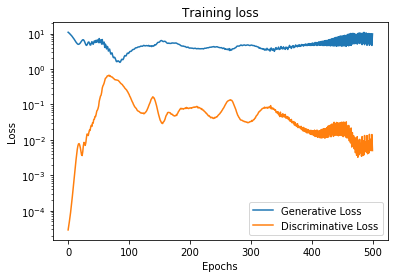

In [13]:
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y


def train(GAN, G, D, epochs=500, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))

        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss


d_loss, g_loss = train(GAN, G, D, verbose=True)

ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.show()